# K Means Model

In [25]:
# Import packages

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


In [3]:
# Import data

transactions = pd.read_excel('../../Data/grocery_database.xlsx', sheet_name = 'transactions')
product_areas = pd.read_excel('../../Data/grocery_database.xlsx', sheet_name = 'product_areas')

In [9]:
transactions = pd.merge(transactions, product_areas, how = 'inner', on = 'product_area_id')
transactions.head(1)

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost,product_area_name_x,profit_margin_x,product_area_name_y,profit_margin_y,product_area_name,profit_margin
0,1,2020-04-10,435657533999,3,7,19.16,Fruit,0.14,Fruit,0.14,Fruit,0.14


In [11]:
transactions.drop(transactions[transactions['product_area_name'] == 'Non-Food'].index, inplace=True)
transactions['product_area_name'].value_counts()

product_area_name
Fruit         8699
Vegetables    8473
Dairy         7360
Meat          6190
Name: count, dtype: int64

In [14]:
transactions_summary = transactions.groupby(['customer_id','product_area_name'])['sales_cost'].sum().reset_index()
transactions_summary.head()

,customer_id,product_area_name,sales_cost
0,1,Dairy,367.74
1,1,Fruit,276.00
2,1,Meat,543.38
3,1,Vegetables,167.12
4,2,Dairy,150.63


In [19]:
# Pivot data to get sales per each area name
transactions_summary_pivot = transactions.pivot_table(index = 'customer_id',  # Column to aggregate from
                                                      columns = 'product_area_name',  # Column to divide with
                                                      values = 'sales_cost',  # Column to aggregate
                                                      aggfunc = 'sum',  # Type of aggregation
                                                      fill_value = 0,  # Replace nan with
                                                      margins = True, # Enables Total column
                                                      margins_name = 'Total'  # Sets the name of the total column
                                                      ).rename_axis(None, axis=1) # Removes initial index column
transactions_summary_pivot.head()

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,367.74,276.00,543.38,167.12,1354.24
2,150.63,120.93,241.21,99.05,611.82
3,46.20,75.39,171.13,31.50,324.22
4,341.91,245.36,272.79,142.35,1002.41
5,694.71,815.32,1405.19,350.10,3265.32


In [ ]:
# Get % of sales in pivot
transactions_summary_pivot = transactions_summary_pivot.div(transactions_summary_pivot['Total'], axis = 0)
transactions_summary_pivot.head()

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,1.0
2,0.246200,0.197656,0.394250,0.161894,1.0
3,0.142496,0.232527,0.527821,0.097156,1.0
4,0.341088,0.244770,0.272134,0.142008,1.0
5,0.212754,0.249691,0.430338,0.107218,1.0


In [23]:
data_for_clustering = transactions_summary_pivot.drop(['Total'], axis=1)
data_for_clustering.head()

,Dairy,Fruit,Meat,Vegetables
customer_id,,,,
1,0.271547,0.203804,0.401244,0.123405
2,0.246200,0.197656,0.394250,0.161894
3,0.142496,0.232527,0.527821,0.097156
4,0.341088,0.244770,0.272134,0.142008
5,0.212754,0.249691,0.430338,0.107218


In [ ]:
# Check for nan
data_for_clustering.isna().sum()

Dairy         0
Fruit         0
Meat          0
Vegetables    0
dtype: int64

In [ ]:
# Normalise data for better algorythm
scale_norm = MinMaxScaler()

data_for_clustering_scaled =pd.DataFrame( scale_norm.fit_transform(data_for_clustering), columns = data_for_clustering.columns)
data_for_clustering_scaled.head()

,Dairy,Fruit,Meat,Vegetables
0,0.309044,0.250873,0.432358,0.164665
1,0.280196,0.243305,0.424823,0.216022
2,0.162172,0.286229,0.568751,0.129640
3,0.388187,0.301300,0.293237,0.189487
4,0.242132,0.307357,0.463709,0.143065


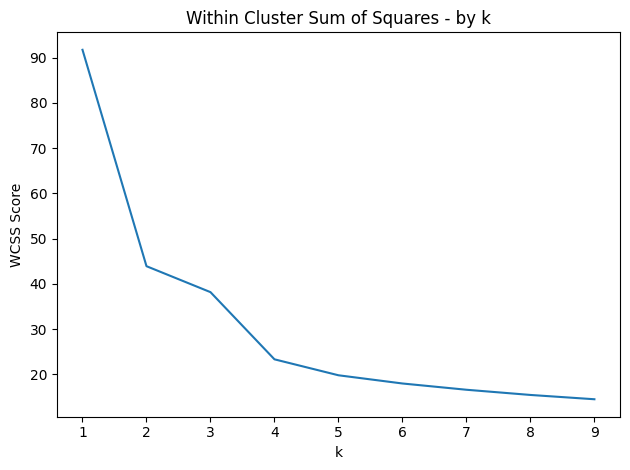

In [29]:
# Make a plot of wcss values for each k 
k_values = list(range(1,10))

wcss_list = []

for k in k_values:
    kmeans = KMeans(n_clusters=k,
                    random_state=42
                    )
    kmeans.fit(data_for_clustering_scaled)
    wcss_list.append(kmeans.inertia_)

plt.plot(k_values, wcss_list)
plt.title('Within Cluster Sum of Squares - by k')
plt.xlabel('k')
plt.ylabel('WCSS Score')
plt.tight_layout()
plt.show()

In [30]:
# Instantiate Model
kmeans = KMeans(n_clusters=3,
                random_state=42
                )

In [32]:
# Fit Model
kmeans.fit(data_for_clustering_scaled)

KMeans(n_clusters=3, random_state=42)

In [34]:
# Add Cluster Labels to the Data
data_for_clustering['cluster'] = kmeans.labels_
data_for_clustering.head()

,Dairy,Fruit,Meat,Vegetables,cluster
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,0
2,0.246200,0.197656,0.394250,0.161894,0
3,0.142496,0.232527,0.527821,0.097156,0
4,0.341088,0.244770,0.272134,0.142008,1
5,0.212754,0.249691,0.430338,0.107218,0


In [36]:
# Check Cluster Size
data_for_clustering['cluster'].value_counts(normalize=True)

cluster
0    0.413318
1    0.349024
2    0.237658
Name: proportion, dtype: float64

In [39]:
# Profile Clusters
cluster_summary = data_for_clustering.groupby('cluster')[['Dairy','Fruit','Meat','Vegetables']].mean().reset_index()
cluster_summary.head()

,cluster,Dairy,Fruit,Meat,Vegetables
0,0,0.238214,0.208101,0.414547,0.139139
1,1,0.212664,0.335928,0.314645,0.136763
2,2,0.181841,0.523302,0.002625,0.292231
